# Coursera Capstone Final Report

Story :
I am going to Paris next month, So i need to find a living place for myself. I am about to complete coursera IBM Data Science Professional Certificate Specialization therefore i have to show my Data Science skill to find a good place in Paris.

This notebook will contain the code to scrape the data from internet with the help of Beautiful Soup and Requests.
<br/>
Plotting Graphs will be there to see the relations between different features of the data
<br/>
Choropleth Graph will be ploted with the help of Folium

    
Let's get started!

## Importing Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import json

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns

import time
import tqdm



# Getting the data: Scraping

We will scrap the data from a website name seloger.com. 
We will scrap script tags which are in source code of the page and the parse the information with the help of BeautifulSoup.

Below is the search-url of 2-rooms apartment.


In [2]:
# This is search-url with different parameters
url = 'https://www.seloger.com/list.htm?org=advanced_search&idtt=1&idtypebien=1&cp=75&tri=initial&nb_pieces=2&naturebien=1,2,4&LISTING-LISTpg=2'

We are using custom headers for making request to pretent ourself as web browser.
We are doing so because sometimes webpages block the ip after so many requests

In [3]:
headers = {'User-Agent': '*',
'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
'Accept-Language': 'en-US,en;q=0.5',
'Accept-Encoding': 'gzip, deflate',
'Connection': 'keep-alive',
'Upgrade-Insecure-Requests': '1'}

In [4]:
s = requests.Session()
s.headers.update(headers)
s.get('http://www.seloger.com/')

<Response [200]>

Now we will iterate over different pages and we will find the script tag from the source code.
<br/>
There is a script tag which contain the details of Apartments.
<br/>
we will parse that details with help of json and retrieve the products/apartments from them and store in our apartment_data list

In [5]:
appartment_data = []
for i in tqdm.tqdm_notebook(range(2, 113)):
    url = url[:-1] + str(i)
    r = s.get(url, headers=headers)
    time.sleep(np.random.uniform(low=1, high=5)) 
    if r.status_code == 200:
        soup = BeautifulSoup(r.text, 'html.parser')
        for script_item in soup.find_all('script'):
            if 'var ava_data' in script_item.text:
                raw_json = script_item.text.split('=')[1][:-23]
        data = json.loads(raw_json)['products']
        appartment_data.append(data)

HBox(children=(IntProgress(value=0, max=111), HTML(value='')))

## Data to DataFrame

Lets create a big dataframe from the scraped data.
<br/>
lets create a function to convert list to dataframe.

In [6]:
def create_df(appartment_data):
    
    df = pd.concat([pd.DataFrame(item) for item in appartment_data])
    df = df.dropna()
    df = df.drop(['affichagetype', 'typedetransaction'], axis=1)
    df = df.drop_duplicates()
    df = df[['codeinsee', 'codepostal', 'etage', 'idagence', 'idannonce', 'idtiers', 'nb_photos',
            'position', 'prix', 'si_balcon', 'surface']]
    df = df.apply(lambda s: pd.to_numeric(s.str.replace(',', '.')))
    # filter out zero surface appartments
    df = df[~(df.surface == 0)]
    
    return df


In [13]:
df = create_df(appartment_data)
df.shape

(219, 11)

In [14]:
df=df.rename(columns={
    'codeinsee':'INSEE_code',
    'etage':'floor',
    'prix':'price',
    'si_balcon':'balcony',
})

In [15]:
df.head()

,INSEE_code,codepostal,floor,idagence,idannonce,idtiers,nb_photos,position,price,balcony,surface
0,750116,75116,0,156068,147793291,178982,8,0,1500,0,30.05
1,750116,75016,0,227641,148083277,263422,6,1,1360,1,41.00
2,750113,75013,0,109207,147585167,164701,13,2,1470,0,41.31
3,750117,75017,0,188694,147988845,244572,9,3,1580,1,47.00
4,750115,75015,0,102541,145643953,153256,8,4,1695,0,60.00


# Plotting

Now we will use Seaborn for plotting

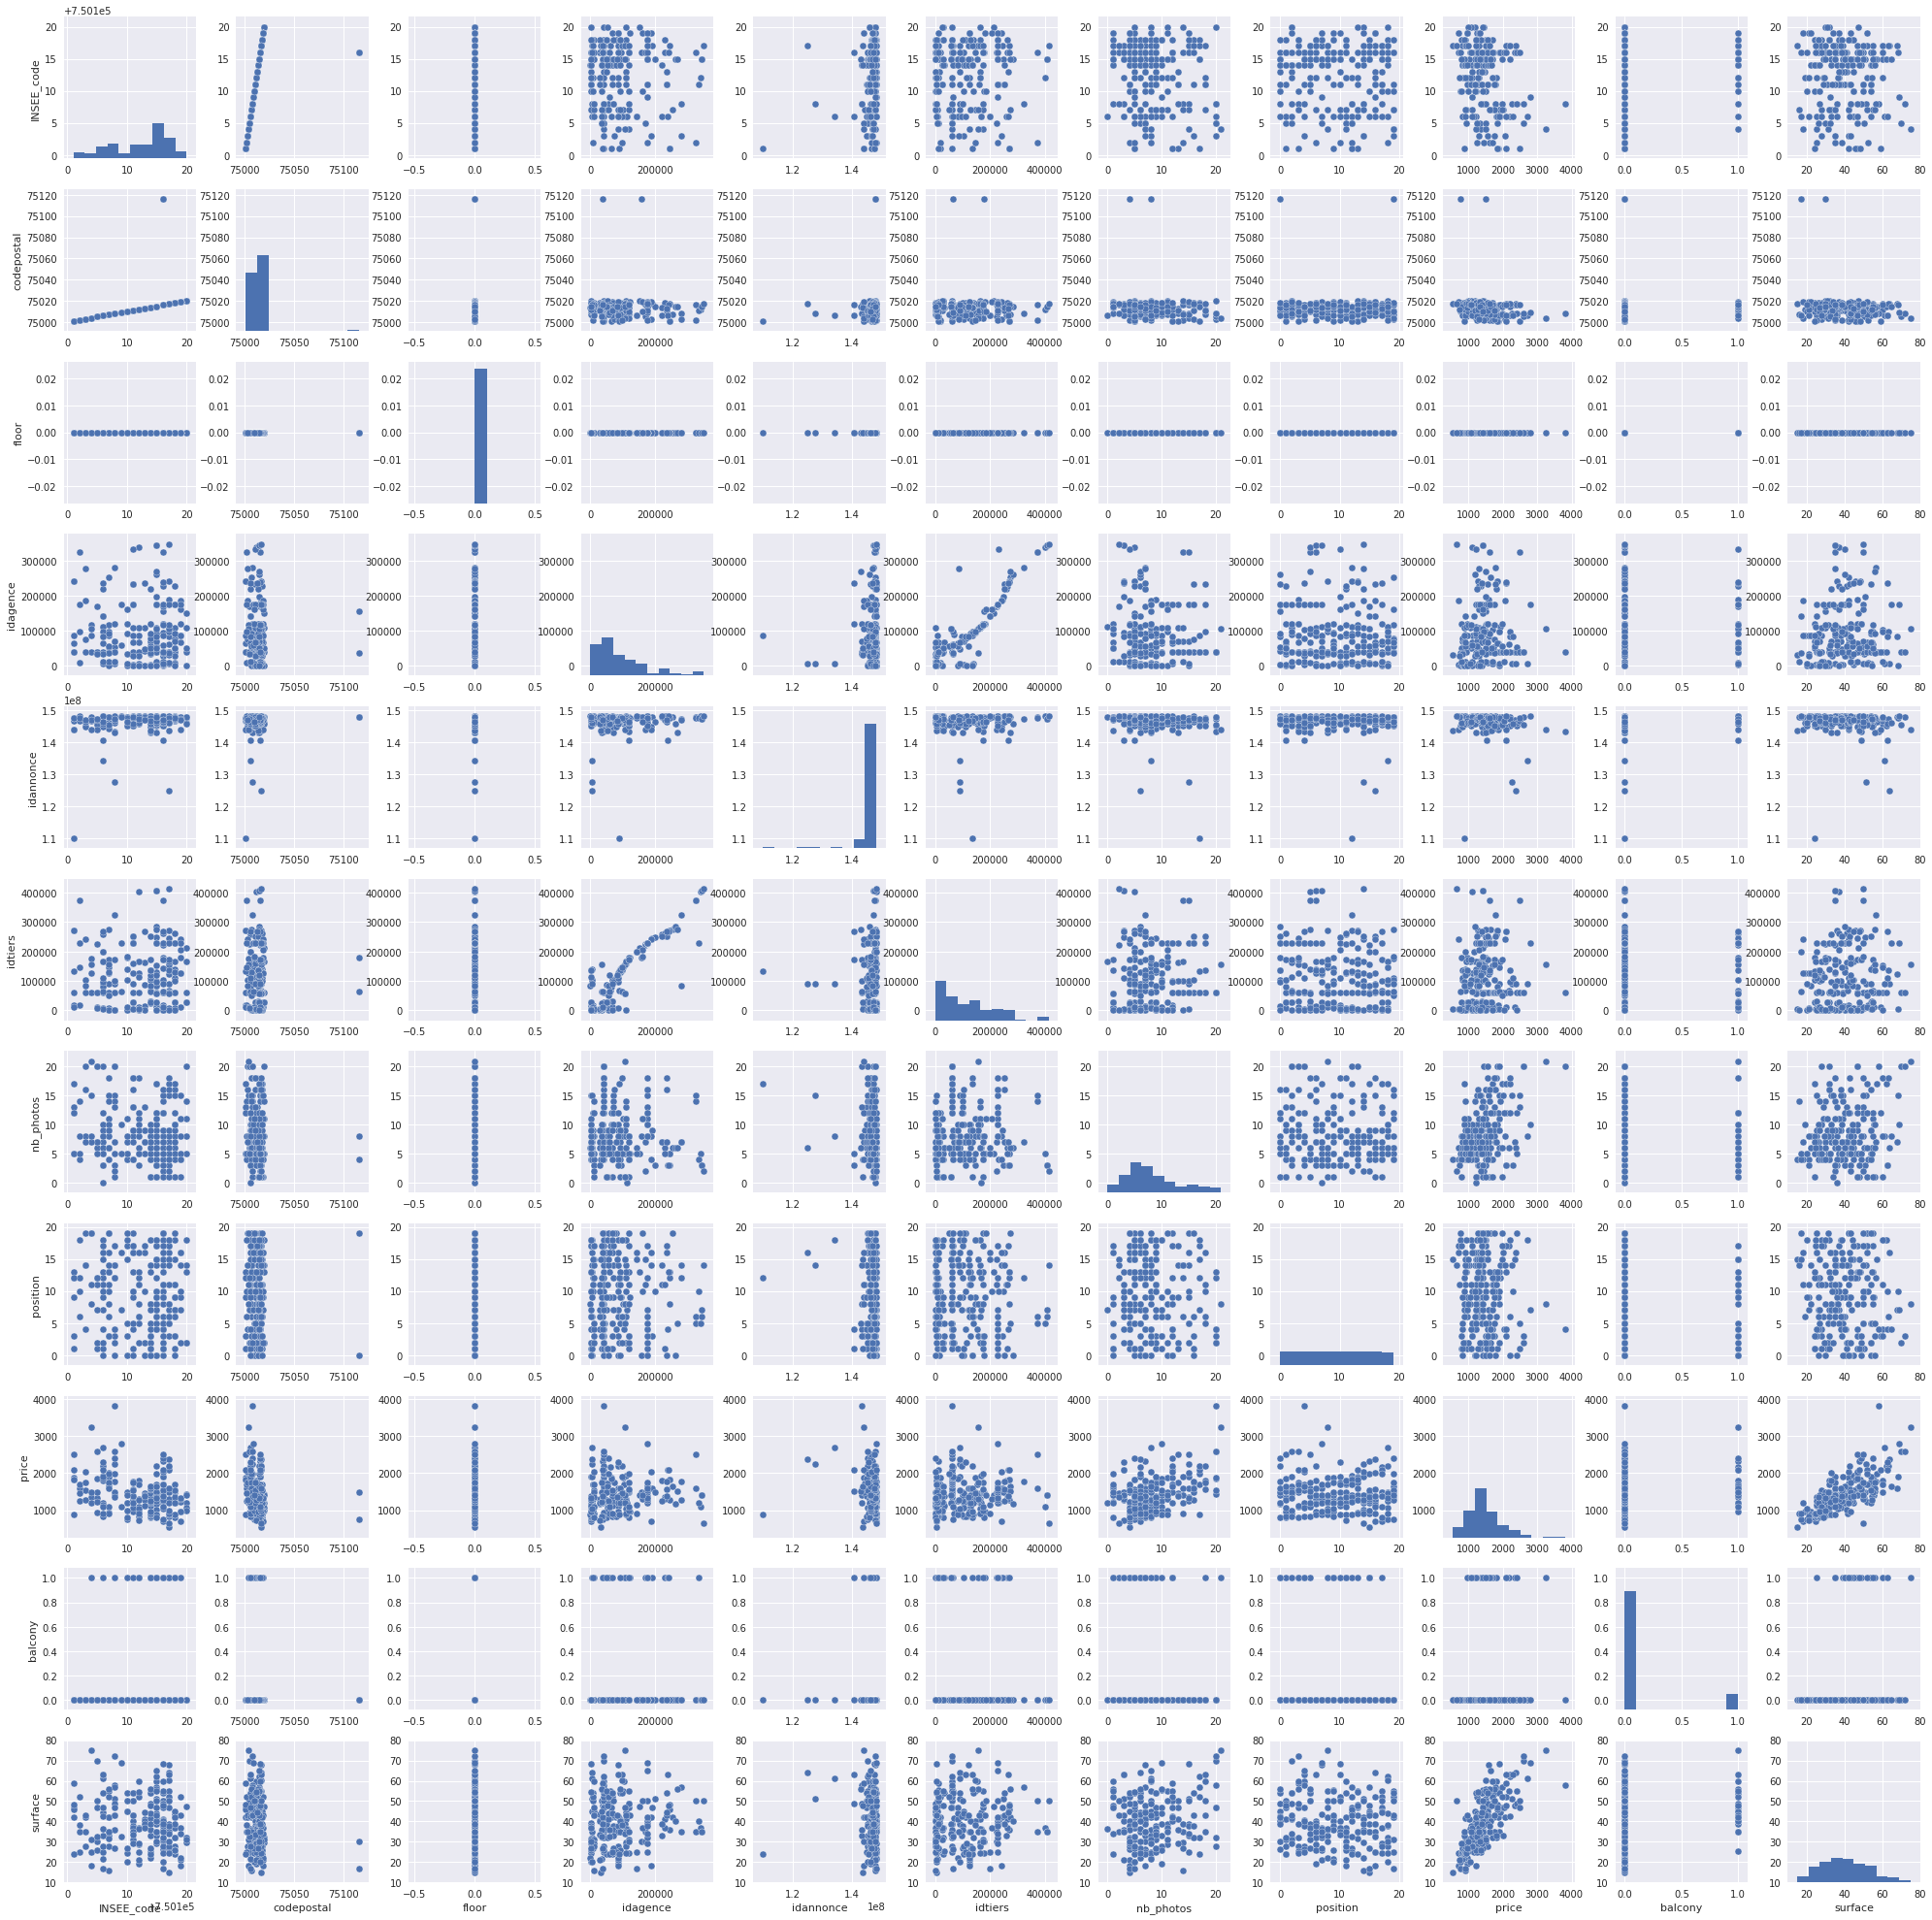

In [16]:
sns.pairplot(df)

This is quite interesting to look at. Let's see if we can uncover some relationships in the data. I can think of a few:

- neighbourhoods: some are better/worse, which should have an impact on the prices
- size of the appartment: larger should be more expensive
- which floor the appartment is one: lower is better?
- balconies: appartments with balconies are more expensive?

Let's look at all these.

## Neighboorhoods 

In [17]:
df['surface_group'] = pd.cut(df.surface, range(0, 100, 20))

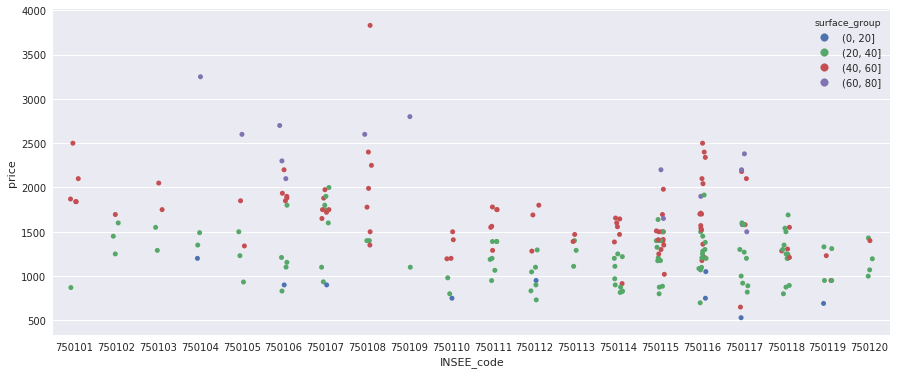

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.stripplot(x="INSEE_code", y="price", hue='surface_group', data=df, jitter=True, ax=ax);

It seems that some neighboorhoods are indeed better than others, since same size appartments are more expensive there. Let's plot the distribution to see that in more detail.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


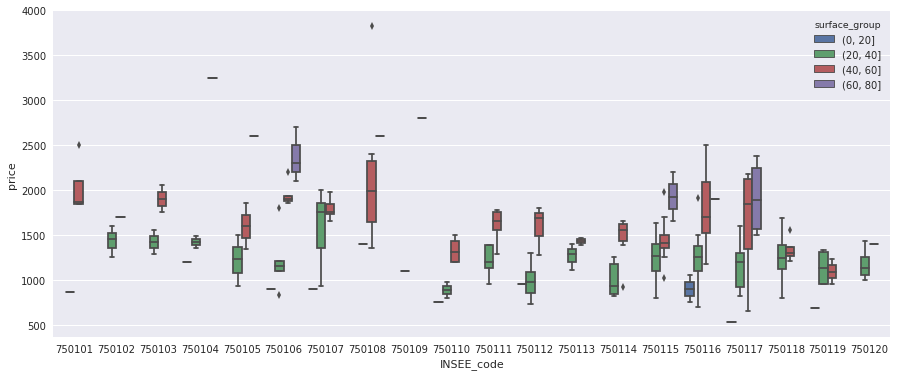

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="INSEE_code", y="price", hue='surface_group', data=df, ax=ax);

We could rank neighboorhoods according to one category of appartment sizes.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


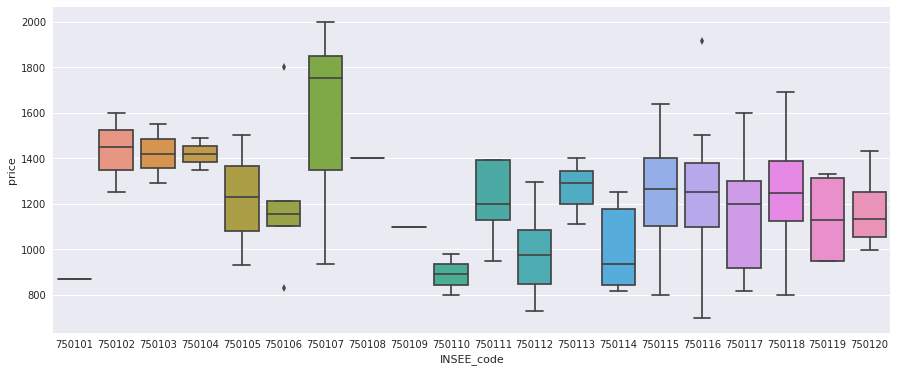

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="INSEE_code", y="price", data=df[df.surface_group == df.surface_group.cat.categories[1]], ax=ax);

Here, it seems the 1st, 3rd, 4th and 8th arrondissement are the most coveted.

Let's plot this as a pivot table.

In [21]:
pivot_table = df.pivot_table(index='INSEE_code', columns=['surface_group'], values='price')
pivot_table

surface_group,"(0, 20]","(20, 40]","(40, 60]","(60, 80]"
INSEE_code,,,,
750101,NaN,870.000000,2030.000000,NaN
750102,NaN,1433.333333,1695.000000,NaN
750103,NaN,1420.000000,1900.000000,NaN
750104,1200.0,1420.000000,NaN,3250.000000
750105,NaN,1221.000000,1595.000000,2600.000000
750106,900.0,1219.400000,1953.400000,2366.666667
750107,900.0,1583.571429,1787.500000,NaN
750108,NaN,1400.000000,2156.857143,2600.000000
750109,NaN,1100.000000,NaN,2800.000000


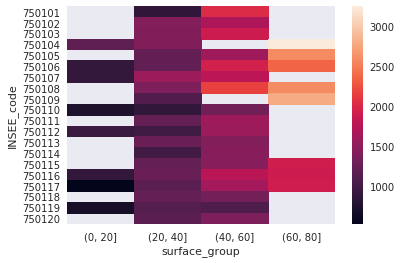

In [35]:
sns.heatmap(pivot_table)

In [36]:
geo_df = pd.DataFrame({'id': [i for i in range(1, 21)], 
                       'price': pivot_table[30].values})
geo_df.head()

,id,price
0,1,870.000000
1,2,1433.333333
2,3,1420.000000
3,4,1420.000000
4,5,1221.000000


In [37]:
!pip install folium
import folium

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [39]:
m = folium.Map(location=[48.87, 2.35], zoom_start=12)
m.choropleth(
    geo_data='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/paris.geojson',
    key_on='feature.properties.cartodb_id',
    data=geo_df,
    columns=['id', 'price'],
    fill_color='OrRd', 
    threshold_scale=[0, 900, 1100, 1300, 1500, 1700],
    highlight=True)
m

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Appartment sizes 

Let's see if we can make out a relationship trend between appartment surface and price.

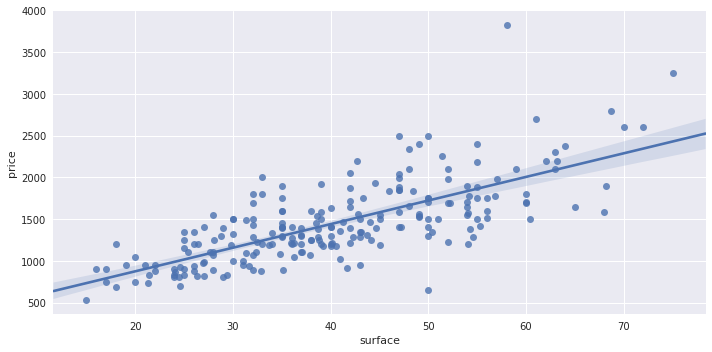

In [40]:
sns.lmplot(x='surface', y='price', data=df, aspect=2)

As expected, the trend goes up.
How does this look like among neighboorhoods?

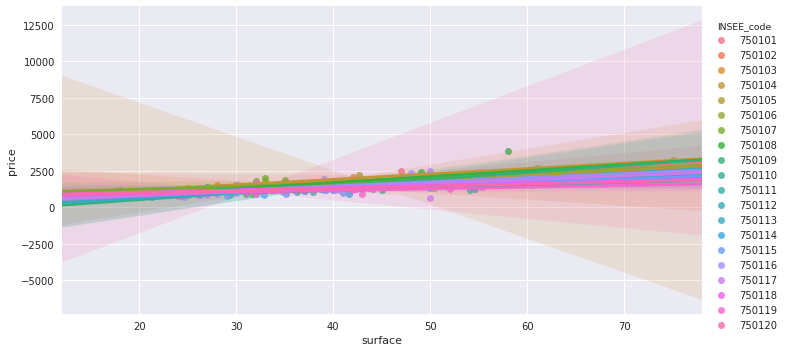

In [41]:
sns.lmplot(x='surface', y='price', hue='INSEE_code', data=df, aspect=2)

This is a surprising curve: the regression coefficient clearly depends on the neighboorhood location! Let's do a choropleth map of the regression coefficient.

First, let's compute the regression lines by hand using scikit-learn.

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
coefs = {}
for code in df.INSEE_code.unique():
    x = df[df.INSEE_code == code]['surface']
    y = df[df.INSEE_code == code]['price']
    reg = LinearRegression()
    reg.fit(x[:, np.newaxis], y[:, np.newaxis])
    coefs[int(str(code)[-2:]) - 1] = reg.coef_[0][0]

In [44]:
geo_df = pd.concat([geo_df['id'], geo_df['price'], pd.Series(coefs, name='coef')], axis=1)

In [45]:
geo_df.head()

,id,price,coef
0,1,870.000000,38.348897
1,2,1433.333333,14.992709
2,3,1420.000000,28.393826
3,4,1420.000000,37.170159
4,5,1221.000000,31.138118


In [46]:
geo_df.describe()

,id,price,coef
count,20.00000,20.000000,20.000000
mean,10.50000,1212.428019,26.565413
std,5.91608,185.652873,9.764043
min,1.00000,870.000000,11.865105
25%,5.75000,1126.250000,19.195704
50%,10.50000,1222.785714,25.643112
75%,15.25000,1300.000000,33.567545
max,20.00000,1583.571429,46.741820


Now, let's plot the coefficient:

In [47]:
min(geo_df['coef'])

11.865104849780268

In [48]:
m = folium.Map(location=[48.87, 2.35], zoom_start=12)
m.choropleth(
    geo_data='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/paris.geojson',
    key_on='feature.properties.cartodb_id',
    data=geo_df,
    columns=['id', 'coef'],
    fill_color='BuPu', 
    threshold_scale=[0, 10, 20, 30, 40, 50],
    legend_name='growth coefficient [Euro/M^2]',
    highlight=True)
m

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Floors 

Let's see where the floors are distributed in the city.

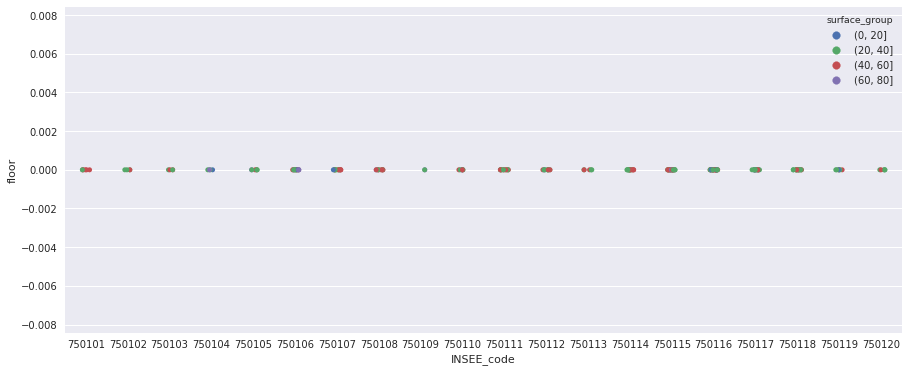

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.stripplot(x="INSEE_code", y="floor", hue='surface_group', data=df, jitter=True, ax=ax);

What's the distribution of floor size and price?

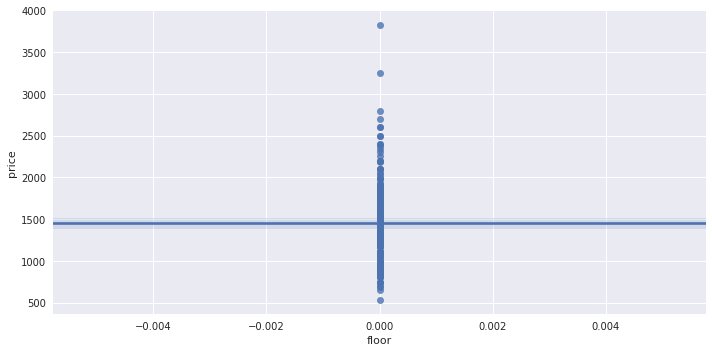

In [50]:
sns.lmplot(x='floor', y='price', data=df, aspect=2)

Almost no dependence on floors. However, a linear model is probably not the best way to represent the data, so I'm not sure this is a good conclusion.

Let's see how this varies with the neighboorhoods.

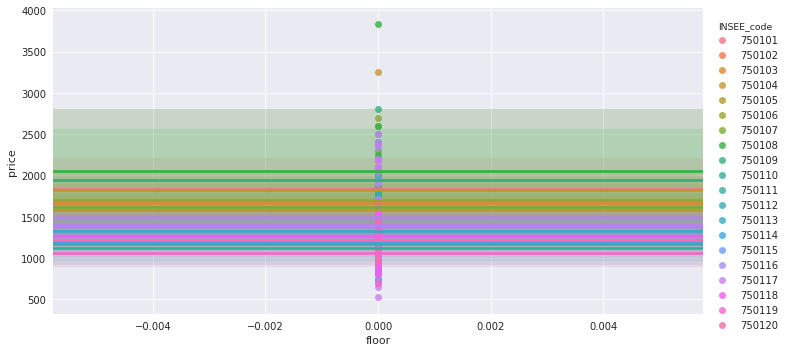

In [51]:
sns.lmplot(x='floor', y='price', hue='INSEE_code', data=df, aspect=2)

Interesting: the model is really bad when extrapolated to non existing floor sizes (most buildings in Paris have a height of four stories).

## Balconies 

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


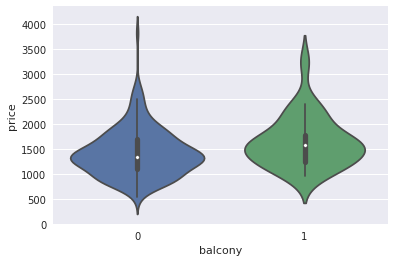

In [52]:
sns.violinplot(x='balcony', y='price', data=df, aspect=2)

Apparently, balconies are worth a little extra money.

# Conclusions

Price of Appartments is directly proportional to appartment size.
<br/>
Balconies bills more money.
<br/>
Overall, 
Appartment in 10th or 12th arrondissement will be beneficial for me.